Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [21]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    !pip install category_encoders==2.*

In [22]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [23]:
# Split train into train & val. Make val the same size as test.
from sklearn.model_selection import train_test_split

target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [24]:
train.shape, val.shape, test.shape

((45042, 41), (14358, 41), (14358, 40))

In [25]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
45793,41413,0.0,2011-03-30,NaN,0,NaN,33.075583,-9.385449,Kwa Mwazembe,0,...,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
26326,48397,500.0,2011-02-28,Dhv,285,DWE,36.228574,-8.207742,Kwamwampwaga,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
53251,6910,0.0,2013-01-27,Finw,218,FinW,39.673635,-10.835281,Pachani,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
26791,12526,500.0,2011-02-27,Adb,1704,DWE,34.915589,-9.016965,Kwa Mwangayange Mfumbilwa,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2162,17511,200.0,2013-01-18,Dwe,1232,DWE,30.332034,-4.308921,Kwa Bungwa,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [26]:

import numpy as np


def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
print(train.shape, val.shape, test.shape)

(45042, 41) (14358, 41) (14358, 40)


In [29]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [30]:
# Ordinal Encoding and Random Forest Classifier
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [37]:
#make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'median'),
    RandomForestClassifier(n_estimators = 143, max_depth = 20, criterion = 'entropy', random_state=42, n_jobs=-1)
)


# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8135534196963365


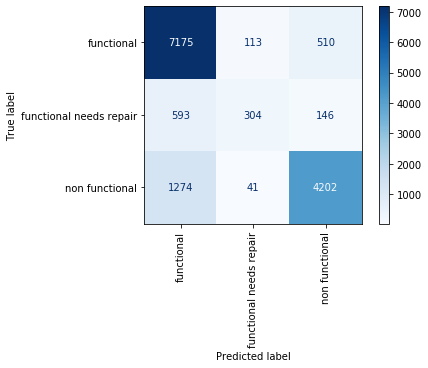

In [42]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline,
                      X_val, y_val, 
                      values_format='.0f', 
                      xticks_rotation='vertical',
                      cmap = 'Blues');

In [38]:
#calulate the overall accuracy
7171 + 304 + 4202

11677

In [41]:
#precison of the 'functional' class
7171/(7175 + 593 + 1274)

0.7930767529307675

In [43]:
#recall for 'function needs repair'
304/(593 + 304 + 146)

0.2914669223394056

In [44]:
#Get the precision
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      7798
functional needs repair       0.66      0.29      0.41      1043
         non functional       0.86      0.76      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.77      0.66      0.69     14358
           weighted avg       0.81      0.81      0.80     14358



In [45]:
# Make predictions for test set
y_pred = pipeline.predict(X_test)

In [46]:
# Make a dataframe with two columns, id and status_group, 
# and write to a csv file, without the index
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission_classification_metrics_1.csv', index=False)